# MIKH Model: Steady-State Flow Curves

## Learning Objectives

1. Fit the **MIKH (Maxwell-Isotropic-Kinematic Hardening)** model to steady-state flow curve data
2. Understand the thixotropic yield stress: $\sigma_y(\lambda) = \sigma_{y0} + \Delta\sigma_y \cdot \lambda$
3. Analyze the interplay between yield stress, kinematic hardening, and viscous contributions
4. Use NLSQ warm-start for efficient Bayesian inference with NUTS
5. Extract posterior distributions for 11 model parameters
6. Calibrate parameters for downstream synthetic data generation (NB03, NB05)

## Prerequisites

- Basic RheoJAX usage (basic/01_quick_start.ipynb)
- Bayesian inference fundamentals (bayesian/01_bayesian_basics.ipynb)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~2-3 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~10-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MIKH

# Add examples/utils to path for tutorial utilities
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_ml_ikh_flow_curve,
    save_ikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_mikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: MIKH Model

The **Maxwell-Isotropic-Kinematic Hardening (MIKH)** model describes thixotropic elasto-viscoplastic materials by combining:
1. Maxwell viscoelastic backbone
2. Armstrong-Frederick kinematic hardening (backstress evolution)
3. Isotropic hardening/softening via structural parameter $\lambda$ (thixotropy)

### Key Equations

**Steady-state flow curve** (at equilibrium structure):
$$
\sigma = \sigma_y(\lambda_{ss}) + \eta_{\infty}|\dot{\gamma}| + \text{plastic contribution}
$$

**Yield surface** (von Mises with backstress):
$$
|\sigma - \alpha| \leq \sigma_y(\lambda) = \sigma_{y0} + \Delta\sigma_y \cdot \lambda
$$

**Structure evolution** (thixotropy):
$$
\frac{d\lambda}{dt} = \frac{1-\lambda}{\tau_{thix}} - \Gamma \lambda |\dot{\gamma}^p|
$$

**Backstress evolution** (Armstrong-Frederick):
$$
d\alpha = C \, d\gamma_p - \gamma_{dyn} |\alpha|^{m-1} \alpha |d\gamma_p|
$$

### Parameters (11 total)

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| **G** | $G$ | Shear modulus (Pa) | 10 - 10000 Pa |
| **eta** | $\eta$ | Maxwell viscosity (Pa·s) | 10 - 10^8 Pa·s |
| **C** | $C$ | Kinematic hardening modulus (Pa) | 10 - 500 Pa |
| **gamma_dyn** | $\gamma_{dyn}$ | Dynamic recovery strain | 0.01 - 10 |
| **m** | $m$ | AF recovery exponent | 0.5 - 2 |
| **sigma_y0** | $\sigma_{y0}$ | Minimal yield stress (Pa) | 1 - 100 Pa |
| **delta_sigma_y** | $\Delta\sigma_y$ | Structural yield contribution (Pa) | 0 - 100 Pa |
| **tau_thix** | $\tau_{thix}$ | Thixotropic rebuilding time (s) | 1 - 1000 s |
| **Gamma** | $\Gamma$ | Structure breakdown coefficient | 0.001 - 10 |
| **eta_inf** | $\eta_{\infty}$ | High-shear viscosity (Pa·s) | 0.01 - 10 Pa·s |
| **mu_p** | $\mu_p$ | Plastic viscosity (Pa·s) | 10^-6 - 1 Pa·s |

### Physical Interpretation

- **Yield stress** ($\sigma_y$): Below this stress, material behaves elastically
- **Thixotropy**: Structure ($\lambda$) rebuilds at rest, breaks down under flow
- **Kinematic hardening**: Backstress $\alpha$ shifts yield surface, causes Bauschinger effect
- **High-shear viscosity**: Newtonian contribution at high rates ($\eta_{\infty}|\dot{\gamma}|$)

## 3. Load Data

We load the steady-state flow curve data from Wei et al. 2018 (J. Rheol), which contains measurements from both ARG2 and ARES rheometers on a thixotropic yield-stress fluid.

In [3]:
# Load ARES rate sweep up data (recommended for flow curve fitting)
gamma_dot, stress = load_ml_ikh_flow_curve(instrument="ARES_up")

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.2f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Data points: 21
Shear rate range: [0.0100, 100.00] 1/s
Stress range: [0.75, 51.46] Pa


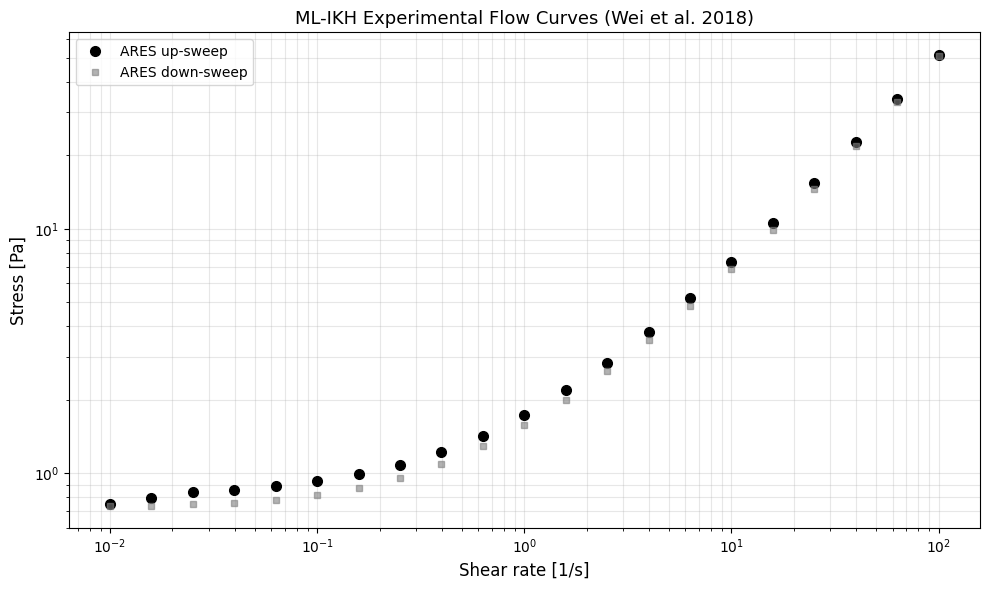

In [4]:
# Also load down-sweep for comparison (hysteresis check)
gamma_dot_down, stress_down = load_ml_ikh_flow_curve(instrument="ARES_down")

# Plot raw data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="ARES up-sweep")
ax.loglog(gamma_dot_down, stress_down, "s", color="gray", markersize=5, 
          alpha=0.6, label="ARES down-sweep")

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("ML-IKH Experimental Flow Curves (Wei et al. 2018)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Initial Fit

We fit the MIKH model to the ARES up-sweep data using NLSQ optimization.

In [5]:
# Create and fit MIKH model
model = MIKH()

t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq = time.time() - t0

# Get parameter names
param_names = get_mikh_param_names()

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=4.789759s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=19 | final_cost=4.1340 | elapsed=4.790s | final_gradient_norm=4.4580e-07


NLSQ fit time: 5.33 s

Fitted parameters:
  G               = 1000
  eta             = 100.2
  C               = 1.376e+04
  gamma_dyn       = 1.621
  m               = 1.369
  sigma_y0        = 1.328
  delta_sigma_y   = 0.01783
  tau_thix        = 4.119e+07
  Gamma           = 3351
  eta_inf         = 0.513
  mu_p            = 0.001


In [6]:
# Compute fit quality
stress_pred = model.predict_flow_curve(gamma_dot)
metrics = compute_fit_quality(stress, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")
print(f"  NRMSE: {metrics['NRMSE']:.4%}")


Fit Quality:
  R^2:   0.997611
  RMSE:  0.6275 Pa
  NRMSE: 1.2374%


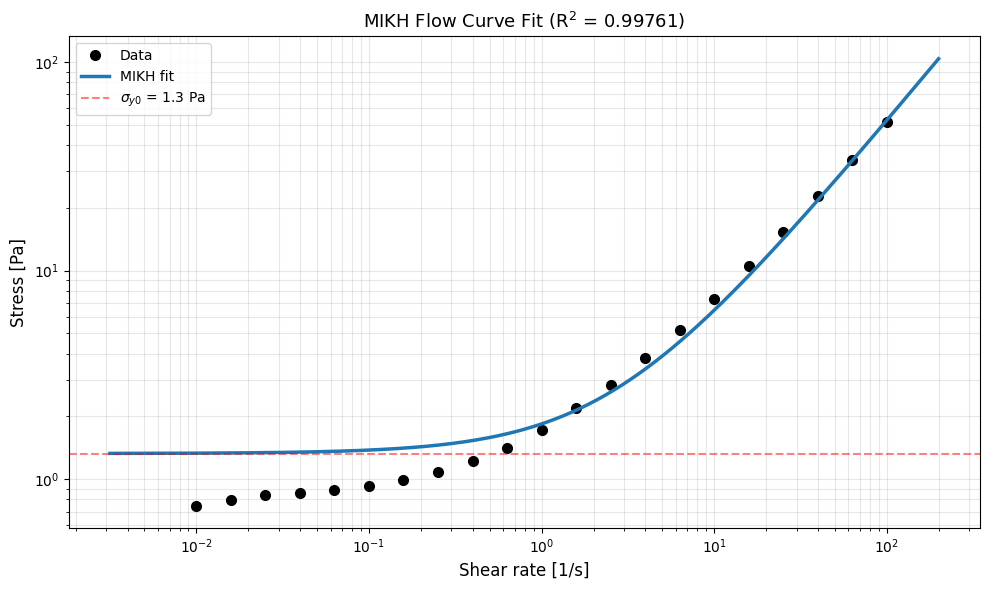

In [7]:
# Plot fit with data
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.3,
    200,
)
stress_pred_fine = model.predict_flow_curve(gamma_dot_fine)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="Data")
ax.loglog(gamma_dot_fine, stress_pred_fine, "-", lw=2.5, color="C0", label="MIKH fit")

# Add Herschel-Bulkley reference line
sigma_y0 = model.parameters.get_value("sigma_y0")
ax.axhline(sigma_y0, color="red", linestyle="--", alpha=0.5, label=f"$\\sigma_{{y0}}$ = {sigma_y0:.1f} Pa")

ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"MIKH Flow Curve Fit (R$^2$ = {metrics['R2']:.5f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Physical Analysis

Let's analyze the contributions from different physical mechanisms.

In [8]:
# Extract key physical parameters
sigma_y0 = model.parameters.get_value("sigma_y0")
delta_sigma_y = model.parameters.get_value("delta_sigma_y")
eta_inf = model.parameters.get_value("eta_inf")
tau_thix = model.parameters.get_value("tau_thix")
Gamma = model.parameters.get_value("Gamma")

print("Physical Analysis:")
print("=" * 50)
print(f"Minimal yield stress (destructured): {sigma_y0:.2f} Pa")
print(f"Maximum yield stress (structured):   {sigma_y0 + delta_sigma_y:.2f} Pa")
print(f"Yield stress range:                  {delta_sigma_y:.2f} Pa")
print(f"High-shear viscosity:                {eta_inf:.4g} Pa.s")
print(f"Thixotropic rebuilding time:         {tau_thix:.2g} s")
print(f"Breakdown coefficient:               {Gamma:.4g}")

Physical Analysis:
Minimal yield stress (destructured): 1.33 Pa
Maximum yield stress (structured):   1.35 Pa
Yield stress range:                  0.02 Pa
High-shear viscosity:                0.513 Pa.s
Thixotropic rebuilding time:         4.1e+07 s
Breakdown coefficient:               3351


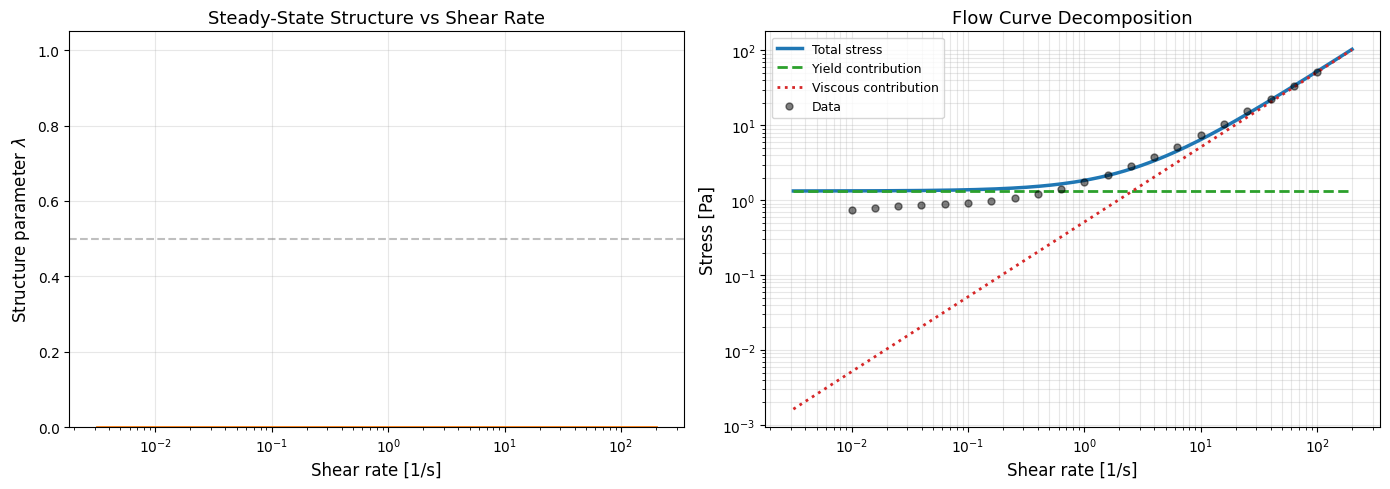

In [9]:
# Decompose flow curve into contributions
from ikh_tutorial_utils import compute_thixotropic_structure, compute_ikh_yield_stress

# Steady-state structure at each shear rate
lambda_ss = compute_thixotropic_structure(gamma_dot_fine, tau_thix, Gamma)
sigma_y_ss = compute_ikh_yield_stress(lambda_ss, sigma_y0, delta_sigma_y)

# Viscous contribution
sigma_viscous = eta_inf * gamma_dot_fine

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Structure evolution
ax1.semilogx(gamma_dot_fine, lambda_ss, lw=2, color="C1")
ax1.set_xlabel("Shear rate [1/s]", fontsize=12)
ax1.set_ylabel("Structure parameter $\\lambda$", fontsize=12)
ax1.set_title("Steady-State Structure vs Shear Rate", fontsize=13)
ax1.set_ylim(0, 1.05)
ax1.axhline(0.5, color="gray", linestyle="--", alpha=0.5)
ax1.grid(True, alpha=0.3)

# Right: Stress decomposition
ax2.loglog(gamma_dot_fine, stress_pred_fine, lw=2.5, color="C0", label="Total stress")
ax2.loglog(gamma_dot_fine, sigma_y_ss, "--", lw=2, color="C2", label="Yield contribution")
ax2.loglog(gamma_dot_fine, sigma_viscous, ":", lw=2, color="C3", label="Viscous contribution")
ax2.loglog(gamma_dot, stress, "ko", markersize=5, alpha=0.5, label="Data")

ax2.set_xlabel("Shear rate [1/s]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Flow Curve Decomposition", fontsize=13)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

We use the NLSQ point estimates as warm-start values for efficient MCMC sampling.

In [10]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}
print("Warm-start values:")
for name, val in initial_values.items():
    print(f"  {name:15s} = {val:.4g}")

# Fast demo config
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

print(f"\nRunning NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  G               = 1000
  eta             = 100.2
  C               = 1.376e+04
  gamma_dyn       = 1.621
  m               = 1.369
  sigma_y0        = 1.328
  delta_sigma_y   = 0.01783
  tau_thix        = 4.119e+07
  Gamma           = 3351
  eta_inf         = 0.513
  mu_p            = 0.001

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:02<31:58,  2.74s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 7/700 [00:02<03:29,  3.30it/s, 1023 steps of size 1.02e-03. acc. prob=0.57]

warmup:   2%|▏         | 11/700 [00:02<02:01,  5.65it/s, 1023 steps of size 1.00e-03. acc. prob=0.72]

warmup:   2%|▏         | 16/700 [00:03<01:12,  9.40it/s, 1023 steps of size 1.47e-03. acc. prob=0.81]

warmup:   3%|▎         | 21/700 [00:03<00:50, 13.42it/s, 1023 steps of size 2.32e-03. acc. prob=0.86]

warmup:   4%|▎         | 25/700 [00:03<00:42, 15.97it/s, 1023 steps of size 3.36e-03. acc. prob=0.88]

warmup:   4%|▍         | 29/700 [00:03<00:34, 19.45it/s, 1023 steps of size 4.55e-03. acc. prob=0.89]

warmup:   5%|▌         | 35/700 [00:03<00:25, 26.06it/s, 1023 steps of size 6.68e-03. acc. prob=0.91]

warmup:   6%|▌         | 40/700 [00:03<00:23, 28.22it/s, 1023 steps of size 6.90e-03. acc. prob=0.92]

warmup:   6%|▋         | 44/700 [00:03<00:22, 28.90it/s, 1023 steps of size 6.34e-03. acc. prob=0.92]

warmup:   7%|▋         | 48/700 [00:04<00:25, 25.78it/s, 511 steps of size 8.26e-03. acc. prob=0.93] 

warmup:   8%|▊         | 53/700 [00:04<00:21, 30.42it/s, 511 steps of size 6.37e-03. acc. prob=0.93]

warmup:   8%|▊         | 58/700 [00:04<00:18, 33.88it/s, 1023 steps of size 6.98e-03. acc. prob=0.93]

warmup:   9%|▉         | 64/700 [00:04<00:16, 39.32it/s, 1023 steps of size 7.86e-03. acc. prob=0.94]

warmup:  10%|█         | 70/700 [00:04<00:14, 43.80it/s, 511 steps of size 9.71e-03. acc. prob=0.94] 

warmup:  11%|█         | 75/700 [00:04<00:15, 39.95it/s, 511 steps of size 8.41e-03. acc. prob=0.94]

warmup:  11%|█▏        | 80/700 [00:04<00:14, 41.59it/s, 1023 steps of size 7.46e-03. acc. prob=0.94]

warmup:  12%|█▏        | 85/700 [00:04<00:16, 38.40it/s, 1023 steps of size 4.20e-03. acc. prob=0.94]

warmup:  13%|█▎        | 92/700 [00:04<00:13, 43.76it/s, 1023 steps of size 5.05e-03. acc. prob=0.95]

warmup:  14%|█▍        | 97/700 [00:05<00:14, 42.74it/s, 1023 steps of size 4.60e-03. acc. prob=0.95]

warmup:  15%|█▍        | 102/700 [00:05<00:13, 44.28it/s, 63 steps of size 5.49e-02. acc. prob=0.95] 

warmup:  17%|█▋        | 120/700 [00:05<00:07, 79.57it/s, 63 steps of size 8.78e-02. acc. prob=0.96]

warmup:  19%|█▉        | 134/700 [00:05<00:05, 94.43it/s, 31 steps of size 1.14e-01. acc. prob=0.96]

warmup:  22%|██▏       | 156/700 [00:05<00:04, 127.04it/s, 63 steps of size 6.82e-02. acc. prob=0.96]

warmup:  25%|██▍       | 174/700 [00:05<00:03, 141.58it/s, 31 steps of size 1.17e-01. acc. prob=0.96]

warmup:  28%|██▊       | 193/700 [00:05<00:03, 153.76it/s, 15 steps of size 1.68e-01. acc. prob=0.97]

sample:  31%|███       | 217/700 [00:05<00:02, 176.84it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  34%|███▍      | 239/700 [00:05<00:02, 188.97it/s, 15 steps of size 1.42e-01. acc. prob=0.99]

sample:  37%|███▋      | 261/700 [00:06<00:02, 197.11it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  43%|████▎     | 298/700 [00:06<00:01, 245.15it/s, 15 steps of size 1.42e-01. acc. prob=0.99]

sample:  46%|████▋     | 324/700 [00:06<00:01, 247.28it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  50%|████▉     | 349/700 [00:06<00:01, 182.16it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  53%|█████▎    | 370/700 [00:06<00:01, 188.49it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  56%|█████▌    | 391/700 [00:06<00:01, 179.74it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  59%|█████▉    | 415/700 [00:06<00:01, 193.80it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  62%|██████▏   | 436/700 [00:06<00:01, 193.08it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  65%|██████▌   | 457/700 [00:07<00:01, 184.58it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  72%|███████▏  | 501/700 [00:07<00:00, 251.48it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  77%|███████▋  | 536/700 [00:07<00:00, 278.01it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  81%|████████  | 566/700 [00:07<00:00, 280.89it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  85%|████████▌ | 595/700 [00:07<00:00, 216.16it/s, 15 steps of size 1.42e-01. acc. prob=0.99]

sample:  90%|█████████ | 630/700 [00:07<00:00, 243.25it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample:  94%|█████████▍| 657/700 [00:07<00:00, 237.43it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:07<00:00, 285.27it/s, 31 steps of size 1.42e-01. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:07<00:00, 88.64it/s, 31 steps of size 1.42e-01. acc. prob=0.99] 


Bayesian inference time: 13.8 s


### 5.2 Convergence Diagnostics

Check R-hat (target < 1.05) and effective sample size (ESS, target > 100 for demo).

In [11]:
# Convergence diagnostics table
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       500      PASS
            eta    1.0000       500      PASS
              C    1.0000       500      PASS
      gamma_dyn    1.0000       500      PASS
              m    1.0000       500      PASS
       sigma_y0    1.0000       500      PASS
  delta_sigma_y    1.0000       500      PASS
       tau_thix    1.0000       500      PASS
          Gamma    1.0000       500      PASS
        eta_inf    1.0000       500      PASS
           mu_p    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


### 5.3 ArviZ Diagnostic Plots

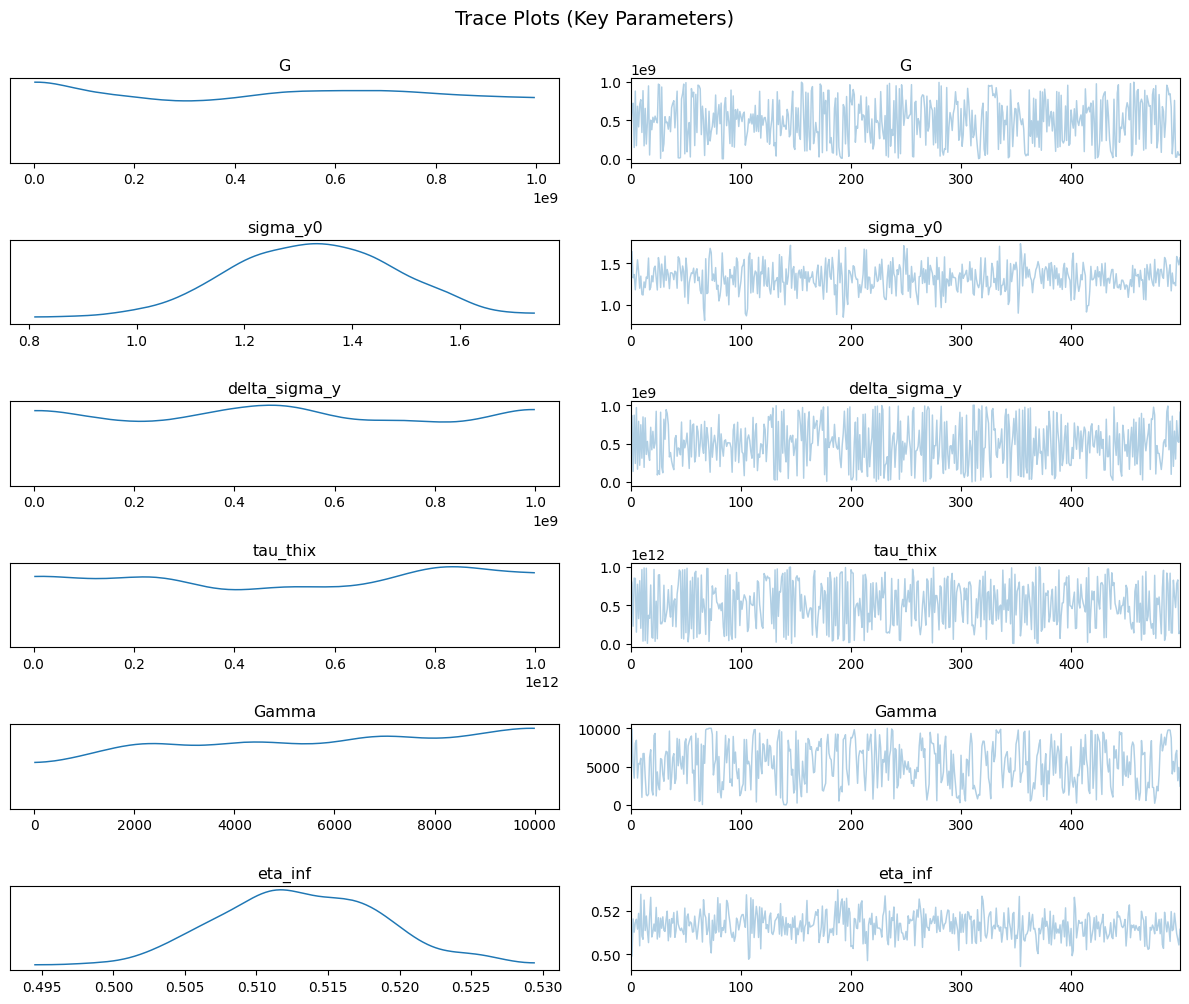

In [12]:
# Trace plots for key parameters
idata = result.to_inference_data()

# Select key physical parameters for visualization
key_params = ["G", "sigma_y0", "delta_sigma_y", "tau_thix", "Gamma", "eta_inf"]
axes = az.plot_trace(idata, var_names=key_params, figsize=(12, 10))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Key Parameters)", fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

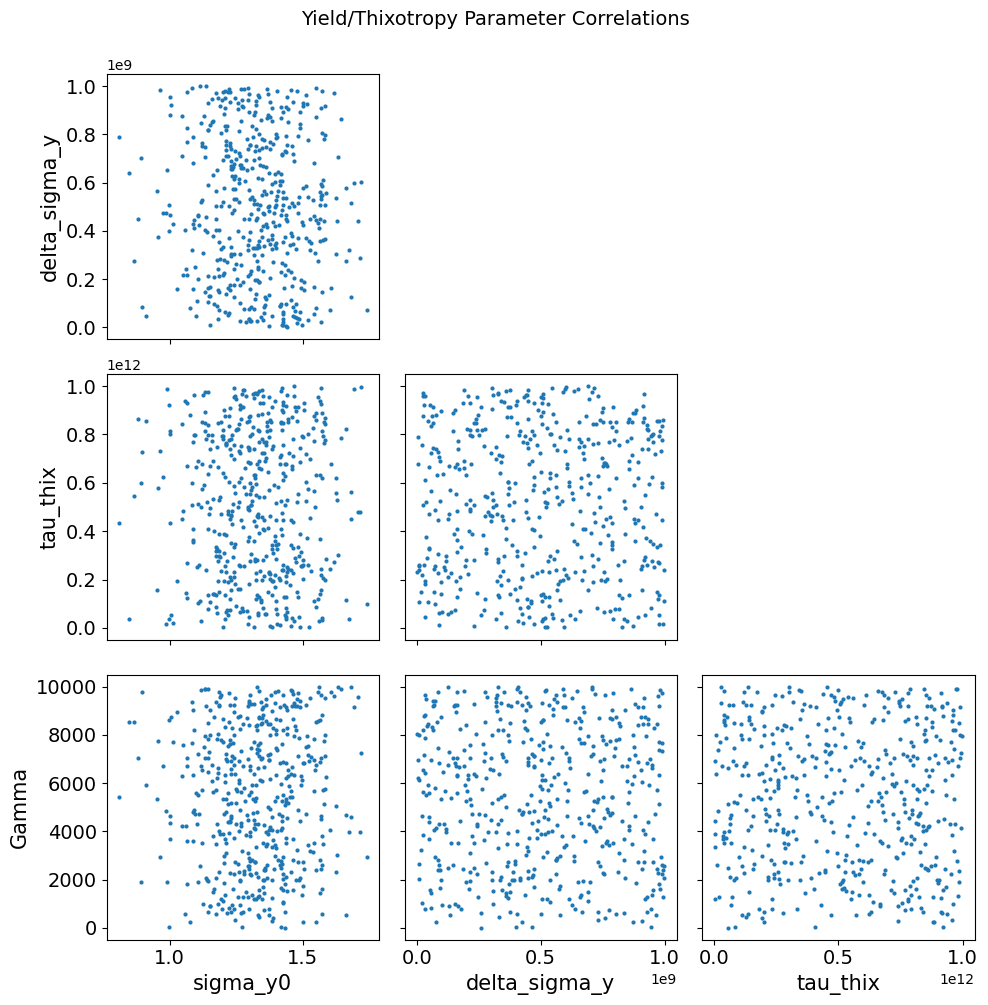

In [13]:
# Pair plot for yield stress parameters
yield_params = ["sigma_y0", "delta_sigma_y", "tau_thix", "Gamma"]
axes = az.plot_pair(
    idata,
    var_names=yield_params,
    kind="scatter",
    divergences=True,
    figsize=(10, 10),
)
fig = axes.ravel()[0].figure
fig.suptitle("Yield/Thixotropy Parameter Correlations", fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

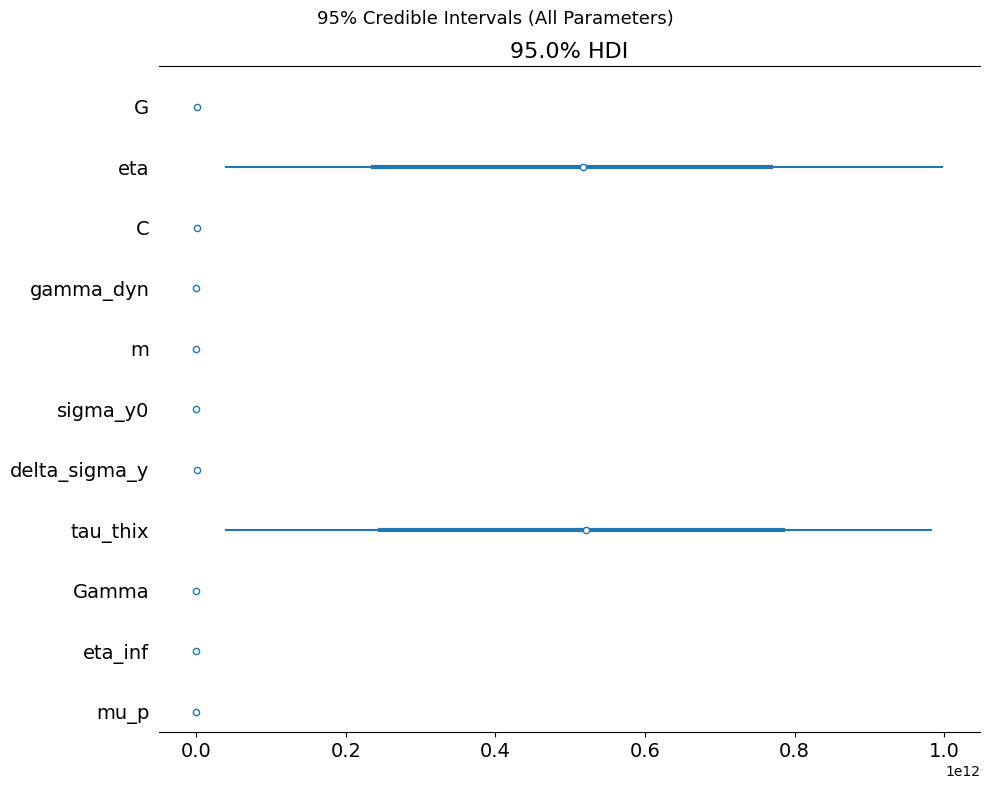

In [14]:
# Forest plot (credible intervals) for all parameters
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 8),
)
fig = axes.ravel()[0].figure
fig.suptitle("95% Credible Intervals (All Parameters)", fontsize=13)
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.4 Posterior Predictive Check

Validate the model by comparing data against predictions from posterior samples.

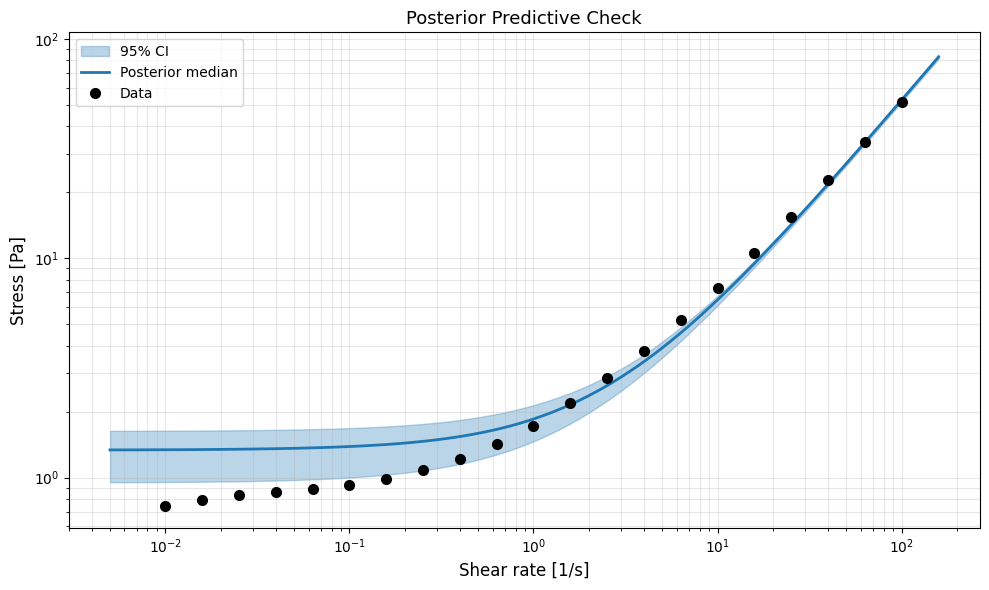

In [15]:
# Posterior predictive with 95% credible intervals
posterior = result.posterior_samples
n_draws = min(200, len(list(posterior.values())[0]))
gamma_dot_pred = np.logspace(
    np.log10(gamma_dot.min()) - 0.3,
    np.log10(gamma_dot.max()) + 0.2,
    100,
)

pred_samples = []
for i in range(n_draws):
    params_i = jnp.array([posterior[name][i] for name in param_names])
    pred_i = model.model_function(jnp.array(gamma_dot_pred), params_i, test_mode="flow_curve")
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(gamma_dot_pred, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
ax.loglog(gamma_dot_pred, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.loglog(gamma_dot, stress, "ko", markersize=7, label="Data")
ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("Posterior Predictive Check", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.5 Parameter Summary

Compare NLSQ point estimates with Bayesian posterior medians and 95% credible intervals.

In [16]:
# NLSQ vs Bayesian comparison table
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G          1000     5.031e+08  [1.668e+07, 9.624e+08]
            eta         100.2     5.166e+11  [1.389e+10, 9.834e+11]
              C     1.376e+04     5.411e+08  [3.865e+07, 9.741e+08]
      gamma_dyn         1.621          5001  [392.8, 9587]
              m         1.369         1.784  [0.5316, 2.942]
       sigma_y0         1.328         1.327  [0.9947, 1.627]
  delta_sigma_y       0.01783     4.975e+08  [2.607e+07, 9.785e+08]
       tau_thix     4.119e+07      5.21e+11  [2.79e+10, 9.75e+11]
          Gamma          3351          5423  [519.5, 9794]
        eta_inf         0.513        0.5128  [0.5024, 0.5251]
           mu_p         0.001         480.1  [53.97, 978.3]


## 6. Physical Interpretation

### Thixotropic Yield Stress

The MIKH model captures the essence of thixotropic yield-stress fluids:

- **At rest** ($\dot{\gamma} \to 0$): Structure builds up ($\lambda \to 1$), yield stress is maximum
- **Under flow**: Structure breaks down ($\lambda < 1$), yield stress decreases
- **Steady state**: Balance between rebuilding and breakdown determines $\lambda_{ss}$

### Flow Curve Regimes

1. **Low shear rates** ($\dot{\gamma} \ll \Gamma^{-1}$): 
   - Structure remains intact ($\lambda \approx 1$)
   - Stress approaches maximum yield stress $\sigma_{y0} + \Delta\sigma_y$

2. **Intermediate shear rates**:
   - Structure breakdown reduces yield stress
   - Shear-thinning behavior emerges

3. **High shear rates** ($\dot{\gamma} \gg \Gamma^{-1}$):
   - Structure fully destroyed ($\lambda \to 0$)
   - Stress dominated by $\sigma_{y0} + \eta_{\infty}\dot{\gamma}$

## 7. Save Results

Save parameters for use in synthetic data generation (NB03: Relaxation, NB05: SAOS).

In [17]:
# Save results for downstream notebooks
save_ikh_results(model, result, "mikh", "flow_curve", param_names)

print("\nParameters saved for synthetic data generation in:")
print("  - NB03: Stress Relaxation")
print("  - NB05: SAOS")

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mikh/flow_curve/
  nlsq_params_flow_curve.json: 11 parameters
  posterior_flow_curve.json: 500 draws

Parameters saved for synthetic data generation in:
  - NB03: Stress Relaxation
  - NB05: SAOS


## Key Takeaways

1. **MIKH model captures thixotropic flow curves** with structure-dependent yield stress:
   $\sigma_y(\lambda) = \sigma_{y0} + \Delta\sigma_y \cdot \lambda$

2. **Structure evolution** balances aging (rebuilding) and flow-induced breakdown:
   $\frac{d\lambda}{dt} = \frac{1-\lambda}{\tau_{thix}} - \Gamma\lambda|\dot{\gamma}^p|$

3. **11 parameters** control different physical mechanisms:
   - Elasticity: $G$, $\eta$
   - Kinematic hardening: $C$, $\gamma_{dyn}$, $m$
   - Yield/Thixotropy: $\sigma_{y0}$, $\Delta\sigma_y$, $\tau_{thix}$, $\Gamma$
   - Viscosity: $\eta_{\infty}$, $\mu_p$

4. **NLSQ warm-start is critical** for efficient Bayesian inference with 11 parameters

5. **Flow curve data alone** constrains yield and viscosity parameters well, but transient data (startup, relaxation) needed for kinematic hardening parameters

6. **Parameters calibrated here** will be used for synthetic relaxation (NB03) and SAOS (NB05) data generation

### Next Steps

- **NB02**: Startup shear (stress overshoot from structure breakdown + kinematic hardening)
- **NB03**: Stress relaxation (synthetic data from calibrated parameters)
- **NB04**: Creep response (delayed yielding)
- **NB05**: SAOS moduli (synthetic data from calibrated parameters)
- **NB06**: LAOS harmonics (nonlinear oscillatory response)